# 基底関数と正則化

In [43]:
#import 
import pandas as pd
import seaborn as sns
from pyearth import Earth
import scipy
import scipy.linalg
from scipy.interpolate import UnivariateSpline

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model.logistic import LogisticRegression
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf

import patsy as patsy

plt.rcParams['font.family'] = 'Noto Sans CJK JP' #全体のフォントを設定

## 5.2 区分的多項式とスプライン

In [2]:
# Limits
x0, xi0, xi1, x1 = -1, 1.5, 4.5, 7
y0, y1 = 0, 4

# Sine line
xgrid = scipy.linspace(x0, x1, 100)
ygrid = scipy.cos(xgrid)+2

# Random sample
size_sample = 60
err_sample = scipy.randn(size_sample)*.3
x_sample = scipy.linspace(x0, x1, size_sample)
y_sample = scipy.cos(x_sample)+2+err_sample

Text(0.5,1,'3次自然スプライン')

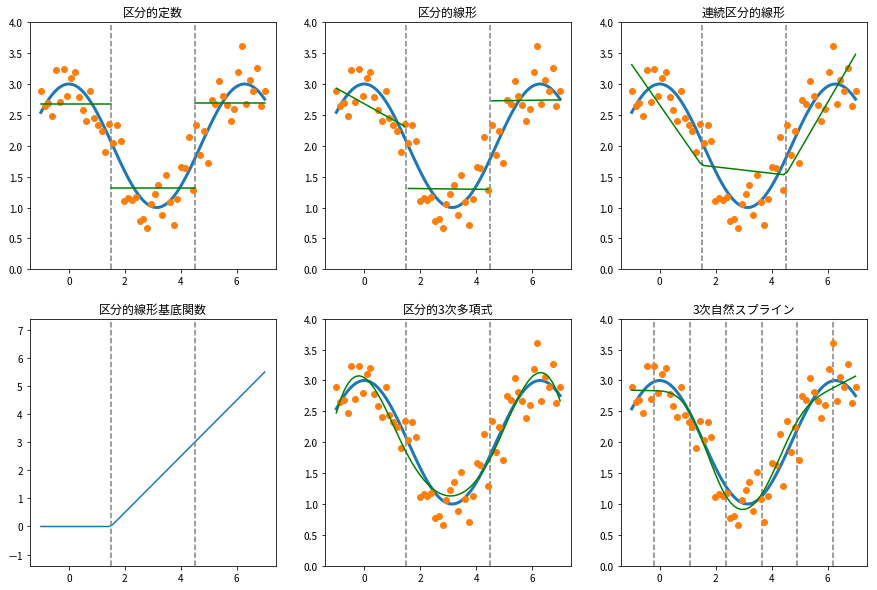

In [3]:
fig51 = plt.figure(51, figsize=(15, 10))
ax1 = fig51.add_subplot(2, 3, 1)
ax1.plot(xgrid, ygrid, linewidth=3)
ax1.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax1.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax1.set_ylim(y0, y1)
ax1.plot(x_sample, y_sample, 'o')

# Split
mask_split1 = x_sample < xi0
mask_split2 = scipy.all([x_sample >= xi0, x_sample < xi1], axis=0)
mask_split3 = xi1 <= x_sample
x_split1 = x_sample[mask_split1]
x_split2 = x_sample[mask_split2]
x_split3 = x_sample[mask_split3]
y_split1 = y_sample[mask_split1]
y_split2 = y_sample[mask_split2]
y_split3 = y_sample[mask_split3]

# 区分的定数
y_split1_mean = y_split1.mean()
y_split2_mean = y_split2.mean()
y_split3_mean = y_split3.mean()
ax1.plot([x0, xi0], [y_split1_mean, y_split1_mean], color='g')
ax1.plot([xi0, xi1], [y_split2_mean, y_split2_mean], color='g')
ax1.plot([xi1, x1], [y_split3_mean, y_split3_mean], color='g')
ax1.set_title(u'区分的定数')

# 区分的線形
y_split1_centered = y_split1-y_split1_mean
y_split2_centered = y_split2-y_split2_mean
y_split3_centered = y_split3-y_split3_mean

beta_split1 = y_split1_centered.dot(x_split1)/(x_split1*x_split1).sum()
beta_split2 = y_split2_centered.dot(x_split2)/(x_split2*x_split2).sum()
beta_split3 = y_split3_centered.dot(x_split3)/(x_split3*x_split3).sum()

y_split1_hat = beta_split1*x_split1+y_split1_mean
y_split2_hat = beta_split2*x_split2+y_split2_mean
y_split3_hat = beta_split3*x_split3+y_split3_mean

ax2 = fig51.add_subplot(2, 3, 2)
ax2.plot(xgrid, ygrid, linewidth=3)
ax2.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax2.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax2.set_ylim(y0, y1)
ax2.plot(x_sample, y_sample, 'o')

ax2.plot(x_split1, y_split1_hat, color='g')
ax2.plot(x_split2, y_split2_hat, color='g')
ax2.plot(x_split3, y_split3_hat, color='g')
ax2.set_title(u'区分的線形')

# 連続区分的線形
h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = scipy.where(x_sample < xi0, 0, x_sample-xi0)
h4 = scipy.where(x_sample < xi1, 0, x_sample-xi1)
H = scipy.vstack((h1, h2, h3, h4)).T

## 最小二乗法
HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ y_sample)
y_hat = H @ beta

ax3 = fig51.add_subplot(2, 3, 3)
ax3.plot(xgrid, ygrid, linewidth=3)
ax3.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax3.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax3.set_ylim(y0, y1)
ax3.plot(x_sample, y_sample, 'o')
ax3.plot(x_sample, y_hat, color='g')
ax3.set_title(u'連続区分的線形')

ax4 = fig51.add_subplot(2, 3, 4)
ax4.plot(x_sample, h3)
ax4.plot([xi0, xi0], ax4.get_xlim(), '--', color='gray')
ax4.plot([xi1, xi1], ax4.get_xlim(), '--', color='gray')
ax4.set_ylim(ax4.get_xlim())
ax4.set_title(u'区分的線形基底関数')

# 3次スプライン
h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = scipy.copy(x_sample*x_sample)
h4 = scipy.copy(x_sample*x_sample*x_sample)
h5 = scipy.where(x_sample < xi0, 0, (x_sample-xi0)**3)
h6 = scipy.where(x_sample < xi1, 0, (x_sample-xi1)**3)
H = scipy.vstack((h1, h2, h3, h4, h5, h6)).T

## 最小二乗法
HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ y_sample)
y_hat_2 = H @ beta

ax5 = fig51.add_subplot(2, 3, 5)
ax5.plot(xgrid, ygrid, linewidth=3)
ax5.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax5.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax5.set_ylim(y0, y1)
ax5.plot(x_sample, y_sample, 'o')
ax5.plot(x_sample, y_hat_2, color='g')
ax5.set_title(u'区分的3次多項式')

# 3次自然スプライン
xis = scipy.array([.1, .26, .42, .58, .74, .9])*8-1
def d(x:scipy.ndarray, xis:scipy.ndarray, k:int)->scipy.ndarray:
    return (scipy.where(x < xis[k], 0, (x-xis[k])**3)
            - scipy.where(x < xis[-1], 0, (x-xis[-1])**3))/(xis[-1]-xis[k])

h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = d(x_sample, xis, 0)-d(x_sample, xis, -2)
h4 = d(x_sample, xis, 1)-d(x_sample, xis, -2)
h5 = d(x_sample, xis, 2)-d(x_sample, xis, -2)
h6 = d(x_sample, xis, 3)-d(x_sample, xis, -2)
H = scipy.vstack((h1, h2, h3, h4, h5, h6)).T

HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ y_sample)
y_hat_3 = H @ beta

ax6 = fig51.add_subplot(2, 3, 6)
ax6.plot(xgrid, ygrid, linewidth=3)
for xi in xis:
    ax6.plot([xi, xi], [y0, y1], '--', color='gray')
ax6.set_ylim(y0, y1)
ax6.plot(x_sample, y_sample, 'o')
ax6.plot(x_sample, y_hat_3, color='g')
ax6.set_title(u'3次自然スプライン')

### 南アフリカの心臓疾患データ
chapter4でロジスティック回帰を行なった結果，以下の通りになった．
```
        Term     Coefficient
--------------------------------
      intercept       -4.129600
            sbp        0.005761
        tobacco        0.079526
            ldl        0.184779
        famhist        0.939185
        obesity       -0.034543
        alcohol        0.000607
            age        0.042541
```           
sbpが有意でない，obesityが負であるのは少し変．

spline + logistic を行って解析

参考
- https://rpubs.com/lance4869/SAheart

In [160]:
df_saheart = pd.read_csv('./data/heart/SAheart.data', index_col=0)
df_saheart['famhist'] = df_saheart['famhist'].map({'Present': 1,
                                                   'Absent': 0})
df_saheart.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [161]:
# model = ['cc(sbp, df=4)', 'cc(tobacco, df=4)', 'cc(ldl, df=4)', 'C(famhist)', 'cc(obesity, df=4)', 'cc(age, df=4)']
model = ['cr(sbp, df=4)', 'cr(tobacco, df=4)', 'cr(ldl, df=4)', 'C(famhist)', 'cr(obesity, df=4)', 'cr(age, df=4)']
# model = ['bs(sbp, df=4)', 'bs(tobacco, df=4)', 'bs(ldl, df=4)', 'C(famhist)', 'bs(obesity, df=4)', 'bs(age, df=4)']

y, X = patsy.dmatrices('chd ~ '+model[0]+'+'+model[1]+'+'+model[2]+'+'+model[3]+'+'+model[4]+'+'+model[5], df_saheart, return_type = 'dataframe')
results = sm.GLM(y, X, family=sm.families.Binomial()).fit()
# results = sm.Logit(y, X, family=sm.families.Binomial()).fit()
# results = sm.GLS(y, X, family=sm.families.Binomial()).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                            GLM   Df Residuals:                      445
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -234.10
Date:                Sat, 26 May 2018   Deviance:                       468.21
Time:                        04:29:12   Pearson chi2:                     452.
No. Iterations:                   100   Covariance Type:             nonrobust
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3041      0.366      0.831      0.406      -0.413       1.021
C(famhist)[T.1]          0.9893      0.233      4.253      0.000       0.533       1.445
cr(sbp, df=4)[0]         0.0590      0.541      0.109      0.913      -1.001       1.119
cr(sbp, df=4)[1]        -0.4901      0.277     -1.771      0.077      -1.032       0.052
cr(sbp, df=4)[2]        -0.3681      0.325     -1.131      0.258      -1.006       0.270
cr(sbp, df=4)[3]         1.1032      0.737      1.497      0.134      -0.341       2.548
cr(tobacco, df=4)[0]    -1.2852      0.583     -2.203      0.028      -2.429      -0.142
cr(tobacco, df=4)[1]    -0.8485      0.469     -1.811      0.070      -1.767       0.070
cr(tobacco, df=4)[2]    -0.6617      0.591     -1.120      0.263      -1.819       0.496
cr(tobacco, df=4)[3]     3.0995      1.842      1.683      0.092      -0.511       6.710
cr(ldl, df=4)[0]        -1.5677      0.808     -1.941      0.052      -3.150       0.015
cr(ldl, df=4)[1]        -0.1772      0.326     -0.544      0.586      -0.815       0.461
cr(ldl, df=4)[2]         0.1507      0.379      0.398      0.691      -0.591       0.893
cr(ldl, df=4)[3]         1.8983      1.033      1.838      0.066      -0.126       3.923
cr(obesity, df=4)[0]     1.5402      1.091      1.412      0.158      -0.598       3.678
cr(obesity, df=4)[1]    -0.7894      0.403     -1.960      0.050      -1.579   -2.88e-06
cr(obesity, df=4)[2]    -1.0257      0.426     -2.408      0.016      -1.861      -0.191
cr(obesity, df=4)[3]     0.5789      1.150      0.503      0.615      -1.675       2.833
cr(age, df=4)[0]        -2.1744      0.736     -2.954      0.003      -3.617      -0.731
cr(age, df=4)[1]         0.3456      0.335      1.031      0.303      -0.311       1.003
cr(age, df=4)[2]         0.6640      0.297      2.233      0.026       0.081       1.247
cr(age, df=4)[3]         1.4689      0.369      3.979      0.000       0.745       2.193
========================================================================================
"""

h1, h2, h3, h4を求めたので，各項に対する自然スプライン関数が描ける

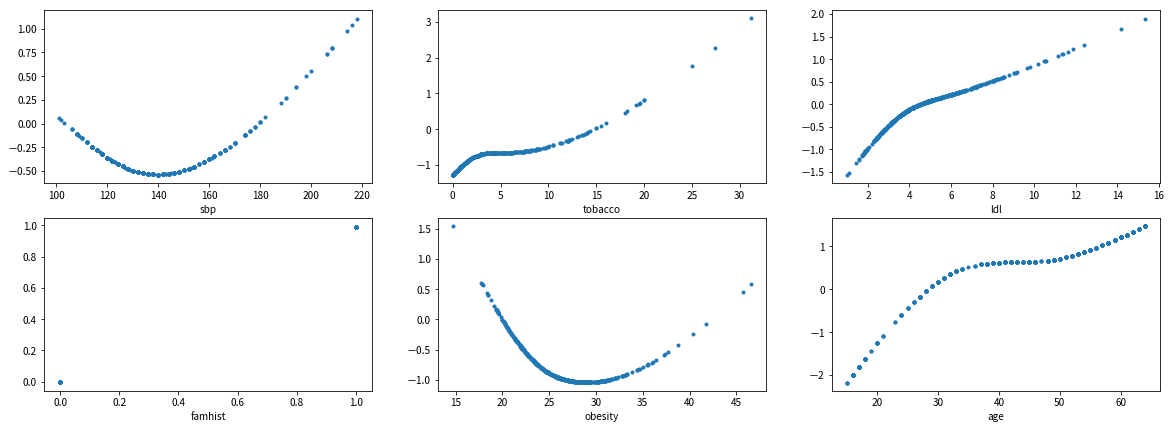

In [162]:
fig51 = plt.figure(51, figsize=(20, 7))

ax1 = fig51.add_subplot(2, 3, 1)
obe = patsy.dmatrix(model[0], df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [results.params[model[0]+'[0]'], results.params[model[0]+'[1]'], 
         results.params[model[0]+'[2]'], results.params[model[0]+'[3]']]
plt.xlabel('sbp')
plt.scatter(df_saheart['sbp'], obe.as_matrix() @ theta, marker=".")

ax2 = fig51.add_subplot(2, 3, 2)
obe = patsy.dmatrix(model[1], df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [results.params[model[1]+'[0]'], results.params[model[1]+'[1]'], 
         results.params[model[1]+'[2]'], results.params[model[1]+'[3]']]
plt.xlabel('tobacco')
plt.scatter(df_saheart['tobacco'], obe.as_matrix() @ theta, marker=".")

ax3 = fig51.add_subplot(2, 3, 3)
obe = patsy.dmatrix(model[2], df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [results.params[model[2]+'[0]'], results.params[model[2]+'[1]'], 
         results.params[model[2]+'[2]'], results.params[model[2]+'[3]']]
plt.xlabel('ldl')
plt.scatter(df_saheart['ldl'], obe.as_matrix() @ theta, marker=".")

ax4 = fig51.add_subplot(2, 3, 4)
obe = patsy.dmatrix(model[3], df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [results.params[model[3]+'[T.1]']]
plt.xlabel('famhist')
plt.scatter(df_saheart['famhist'], obe.as_matrix() @ theta, marker=".")

ax5 = fig51.add_subplot(2, 3, 5)
obe = patsy.dmatrix(model[4], df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [results.params[model[4]+'[0]'], results.params[model[4]+'[1]'], 
         results.params[model[4]+'[2]'], results.params[model[4]+'[3]']]
plt.xlabel('obesity')
plt.scatter(df_saheart['obesity'], obe.as_matrix() @ theta, marker=".")

ax6 = fig51.add_subplot(2, 3, 6)
obe = patsy.dmatrix(model[5], df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [results.params[model[5]+'[0]'], results.params[model[5]+'[1]'], 
         results.params[model[5]+'[2]'], results.params[model[5]+'[3]']]
plt.xlabel('age')
plt.scatter(df_saheart['age'], obe.as_matrix() @ theta, marker=".")

### 音素認識

In [192]:
df_phoneme = pd.read_csv('./data/phoneme/phoneme.data', index_col=0)
print(df_phoneme.shape)
df_phoneme.head()

(4509, 258)


,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,...,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256,g,speaker
row.names,,,,,,,,,,,,,,,,,,,,,
1,9.85770,9.20711,9.81689,9.01692,9.05675,8.92518,11.28308,11.52980,10.79713,9.04747,...,12.68076,11.20767,13.69394,13.72055,12.16628,12.92489,12.51195,9.75527,sh,train.dr1.mcpm0.sa1
2,13.23079,14.19189,15.34428,18.11737,19.53875,18.32726,17.34169,17.16861,19.63557,20.15212,...,8.45714,8.77266,9.59717,8.45336,7.57730,5.38504,9.43063,8.59328,iy,train.dr1.mcpm0.sa1
3,10.81889,9.07615,9.77940,12.20135,12.59005,10.53364,8.54693,9.46049,11.96755,12.05282,...,5.00824,5.51019,5.95725,7.04992,7.02469,6.58416,6.27058,3.85042,dcl,train.dr1.mcpm0.sa1
4,10.53679,9.12147,10.84621,13.92331,13.52476,10.27831,8.97459,11.57109,12.35839,10.47826,...,5.85688,5.40324,6.07126,5.30651,4.27412,3.63384,3.22823,4.63123,dcl,train.dr1.mcpm0.sa1
5,12.96705,13.69454,14.91182,18.22292,18.45390,17.25760,17.79614,17.76387,18.99632,17.40394,...,8.00151,7.58624,6.65202,7.69109,6.93683,7.03600,7.01278,8.52197,aa,train.dr1.mcpm0.sa1


In [193]:
aa_fig = df_phoneme[df_phoneme['g']=='aa'][:10].drop(columns=['g','speaker'])
ao_fig = df_phoneme[df_phoneme['g']=='ao'][:10].drop(columns=['g','speaker'])

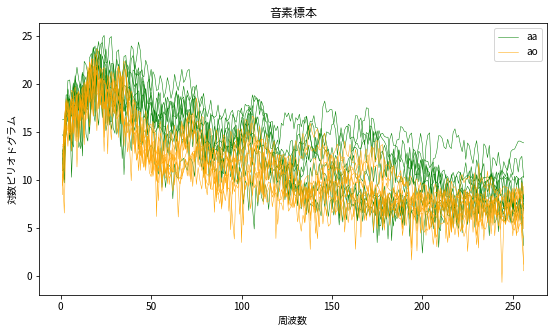

In [194]:
fig55 = plt.figure(55, figsize=(20, 5))
ax = fig55.add_subplot(1, 2, 1)
grid_x = range(1, 257)
plt_aa = ax.plot(grid_x, aa_fig.as_matrix().T,
                 color='green', linewidth=.5, label='aa')
plt_ao = ax.plot(grid_x, ao_fig.as_matrix().T,
                 color='orange', linewidth=.5, label='ao')
ax.legend((plt_aa[0], plt_ao[0]), ('aa', 'ao'))
ax.set_xlabel('周波数')
ax.set_ylabel('対数ピリオドグラム')
ax.set_title('音素標本')
plt.show()

ロジスティック回帰

In [195]:
aa_df = df_phoneme[df_phoneme['g']=='aa']
ao_df = df_phoneme[df_phoneme['g']=='ao']

In [196]:
# アンダーサンプリング
ao_df = ao_df.sample(n=695)
print(aa_df.shape, ao_df.shape)

(695, 258) (695, 258)


In [197]:
dataset = pd.concat([aa_df, ao_df])
X = dataset.drop(columns=['speaker', 'g'])
Y = dataset['g']
Y = Y.map({'aa': 1, 'ao': 0})

In [198]:
mat_X = X.as_matrix()
size_training, size_predictor = mat_X.shape
size_beta = size_predictor + 1

vec_y = Y.as_matrix()
mat_1X = scipy.hstack((scipy.ones((size_training, 1)), mat_X))

def fvec_p(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    num = scipy.exp(mat_x@vec_beta)
    return num/(num+1)

def fdiag_W(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    vec_p = fvec_p(mat_x, vec_beta)
    return vec_p*(1-vec_p)

In [199]:
vec_beta_old = scipy.zeros(size_beta)
vec_increment = scipy.ones(size_beta)
while (vec_increment**2).sum() > 1e-8:
    vec_p = fvec_p(mat_1X, vec_beta_old)
    gradient = mat_1X.T @ (vec_y-vec_p)
    hessian = mat_1X.T @ scipy.diag(fdiag_W(mat_1X, vec_beta_old)) @ mat_1X
    vec_increment = scipy.linalg.solve(hessian, gradient)
    vec_beta_new = vec_beta_old + vec_increment
    vec_beta_old = vec_beta_new.copy()

スプライン

In [200]:
vec_beta_sp = np.delete(vec_beta_new, 0)

grid_x = range(0, 256)
x_sample = scipy.linspace(0, 256, 256)

# 3次自然スプライン
xis = scipy.array([.1, .26, .42, .58, .74, .9])*256-1
def d(x:scipy.ndarray, xis:scipy.ndarray, k:int)->scipy.ndarray:
    return (scipy.where(x < xis[k], 0, (x-xis[k])**3)
            - scipy.where(x < xis[-1], 0, (x-xis[-1])**3))/(xis[-1]-xis[k])

h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = d(x_sample, xis, 0)-d(x_sample, xis, -2)
h4 = d(x_sample, xis, 1)-d(x_sample, xis, -2)
h5 = d(x_sample, xis, 2)-d(x_sample, xis, -2)
h6 = d(x_sample, xis, 3)-d(x_sample, xis, -2)
H = scipy.vstack((h1, h2, h3, h4, h5, h6)).T

HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ vec_beta_sp)
y_hat_4 = H @ beta

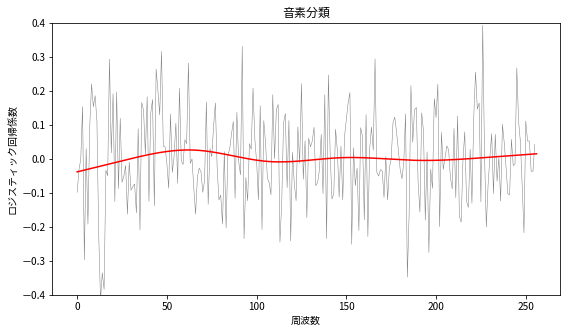

In [201]:
fig55 = plt.figure(55, figsize=(20, 5))
ax = fig55.add_subplot(1, 2, 1)
ax.plot(xgrid, ygrid, linewidth=3)
ax.set_ylim(-0.4, 0.4)
ax.plot(grid_x, vec_beta_sp,
                 color='gray', linewidth=.5)
ax.plot(x_sample, y_hat_4, color='r')
ax.set_xlabel('周波数')
ax.set_ylabel('ロジスティック回帰係数')
ax.set_title(u'音素分類')
plt.show()

## 5.4 平滑化スプライン

In [202]:
df_spmbnd = pd.read_table('./data/spnbmd/spnbmd.data', index_col=0)
df_spmbnd = df_spmbnd.sort_values(by='age')
df_mal = df_spmbnd[df_spmbnd['gender']=='male'].groupby('age').mean().reset_index()
df_fem = df_spmbnd[df_spmbnd['gender']=='female'].groupby('age').mean().reset_index()

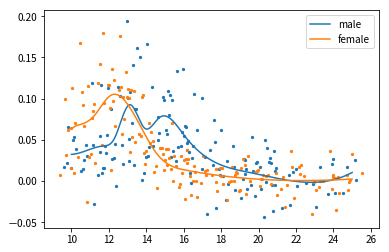

In [203]:
x_mal = df_mal['age'].values
y_mal = df_mal['spnbmd'].values

x_fem = df_fem['age'].values
y_fem = df_fem['spnbmd'].values

spl_mal = UnivariateSpline(x_mal, y_mal)
spl_mal.set_smoothing_factor(0.18)

spl_fem = UnivariateSpline(x_fem, y_fem)
spl_fem.set_smoothing_factor(0.12)

xs = np.linspace(10, 25, 10000)
plt.plot(xs, spl_mal(xs), 'C0', label="male")
plt.plot(xs, spl_fem(xs), 'C1', label="female")
plt.legend()

plt.scatter(x_mal, y_mal, c='C0', s=5)
plt.scatter(x_fem, y_fem, c='C1', s=5)

## 5.7

In [155]:
sample_size = 100
# Parameters for mean distributions
mean_blue = [1, 0]
mean_orange = [0, 1]
mean_cov = scipy.eye(2)
mean_size = 10

# Additional parameters for blue and orange distributions
sample_cov = scipy.eye(2)/5

# Generate mean components for blue and orange (10 means for each)
sample_blue_mean = scipy.random.multivariate_normal(mean_blue, mean_cov, mean_size)
sample_orange_mean = scipy.random.multivariate_normal(mean_orange, mean_cov, mean_size)

# Generate blue points
sample_blue = scipy.array([
    scipy.random.multivariate_normal(sample_blue_mean[r], sample_cov)
    for r in scipy.random.randint(0, 10, 100)
])
y_blue = scipy.zeros(sample_size)

# Generate orange points
sample_orange = scipy.array([
    scipy.random.multivariate_normal(sample_orange_mean[r], sample_cov)
    for r in scipy.random.randint(0, 10, 100)
])
y_orange = scipy.ones(sample_size)

data_x = scipy.concatenate((sample_blue, sample_orange), axis=0)
data_y = scipy.concatenate((y_blue, y_orange))

df_sample = pd.DataFrame(data_x, data_y, columns=['x_1','x_2']).reset_index().rename(columns={'index': 'y'})
df_sample.head()

,y,x_1,x_2
0,0.0,-0.052834,-0.894711
1,0.0,0.310891,-0.297108
2,0.0,0.112386,-0.406881
3,0.0,0.374919,0.081168
4,0.0,-0.369922,0.681948


/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


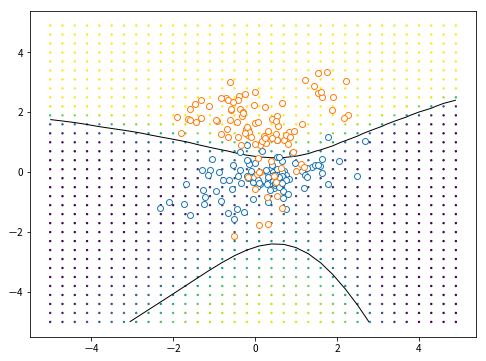

In [227]:
# 加法的自然スプライン，各軸4自由度
model = ['cr(x_1, df=4)', 'cr(x_2, df=4)']
y, X = patsy.dmatrices('y ~ '+model[0]+'+'+model[1], df_sample, return_type = 'dataframe')

logreg = LogisticRegression(C=1e8)
logreg.fit(X, y)
y_pred_logreg = logreg.predict(X)

xx, yy = np.mgrid[-5:5:0.3, -5:5:0.3]
grid = np.c_[xx.ravel(), yy.ravel()]
df_grid = pd.DataFrame(grid, columns=['x_1','x_2'])
X = patsy.dmatrix(model[0]+'+'+model[1], df_grid, return_type = 'dataframe')
probs = logreg.predict_proba(X)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(xx, yy, c=probs, s=2)
plt.contour(xx, yy, probs, linewidths=1, levels=[0.5], colors='k',
                      vmin=0, vmax=1)
plt.plot(sample_blue[:, 0], sample_blue[:, 1],'o',color='white', markeredgecolor='C0')
plt.plot(sample_orange[:, 0], sample_orange[:, 1],'o',color='white', markeredgecolor='C1')

/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


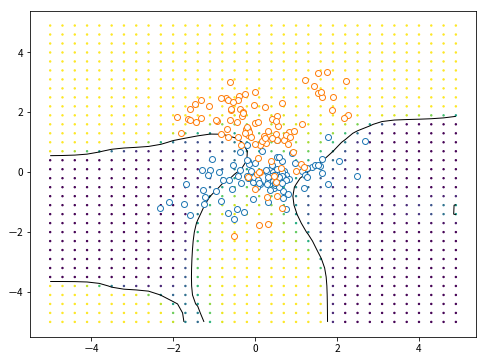

In [231]:
# tensor product
model = ['te(cr(x_1, df=4), cr(x_2, df=4))']
y, X = patsy.dmatrices('y ~ '+model[0], df_sample, return_type = 'dataframe')

logreg = LogisticRegression(C=1e8)
logreg.fit(X, y)
y_pred_logreg = logreg.predict(X)

xx, yy = np.mgrid[-5:5:0.3, -5:5:0.3]
grid = np.c_[xx.ravel(), yy.ravel()]
df_grid = pd.DataFrame(grid, columns=['x_1','x_2'])
X = patsy.dmatrix(model[0], df_grid, return_type = 'dataframe')
probs = logreg.predict_proba(X)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(xx, yy, c=probs, s=2)
plt.contour(xx, yy, probs, linewidths=1, levels=[0.5], colors='k',
                      vmin=0, vmax=1)
plt.plot(sample_blue[:, 0], sample_blue[:, 1],'o',color='white', markeredgecolor='C0')
plt.plot(sample_orange[:, 0], sample_orange[:, 1],'o',color='white', markeredgecolor='C1')